In [79]:
import pandas as pd
df = pd.read_csv("traces_data.csv")
df.head()

,Timestamp,traceID,spanID,parentSpanID,serviceName,Name,durationNano,Column1
0,2023-11-23 04:42:32.707303516,d8d992638d73274d0a6710a1f9d17f93,0d87dcf5ea5aeaab,NaN,featureflagservice,/,887477,NaN
1,2023-11-23 04:42:32.707459680,d8d992638d73274d0a6710a1f9d17f93,bd0a6f75f1a901b7,0d87dcf5ea5aeaab,featureflagservice,featureflagservice.repo.query:featureflags,481634,NaN
2,2023-11-23 04:42:33.930086000,fab7ab123d61c8d7d71062fc44ffb87e,fe4acd4c8a763d24,NaN,frontend-proxy,ingress,213000,NaN
3,2023-11-23 04:42:36.928455000,39a34f6b196aa69cdd5364bfc73b35b4,b3c68f9f4a73524b,NaN,frontend-proxy,ingress,602000,NaN
4,2023-11-23 04:42:39.923633000,61e0ffa4c695a832b05f406999cf319c,b204b9bce1b3ac35,NaN,frontend-proxy,ingress,556000,NaN


In [50]:
df.dtypes

Timestamp       object
traceID         object
spanID          object
parentSpanID    object
serviceName     object
Name            object
durationNano     int64
Column1         object
dtype: object

### Converting 'Timestamp' datatype from object to datetime and sorting the dataframe based on the time-stamp.

In [80]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [52]:
df = df.sort_values(by='Timestamp', ascending=True ).reset_index(drop=True)

In [53]:
df['Timestamp']

0        2023-11-23 02:34:48.848999936
1        2023-11-23 02:34:48.849999872
2        2023-11-23 02:34:48.849999872
3        2023-11-23 02:34:48.849999872
4        2023-11-23 02:34:48.849999872
                      ...             
183610   2023-11-23 04:58:36.622814132
183611   2023-11-23 04:59:06.652472388
183612   2023-11-23 04:59:06.652641179
183613   2023-11-23 04:59:36.766676358
183614   2023-11-23 04:59:36.766831067
Name: Timestamp, Length: 183615, dtype: datetime64[ns]

In [54]:
duration = (df['Timestamp'][len(df)-1] - df['Timestamp'][0])
print(duration)
print(df['Timestamp'][0], " - ", df['Timestamp'][len(df)-1])

0 days 02:24:47.917831131
2023-11-23 02:34:48.848999936  -  2023-11-23 04:59:36.766831067


The data is collected in a duration of 2 hour and 24 minutes i.e. from 23 November 2023 2:34 to same day 4:59

In [86]:
null_values = df.isnull().sum()
null_values

Timestamp            0
traceID              0
spanID               0
parentSpanID     41781
serviceName          0
Name                 0
durationNano         0
Column1         103117
dtype: int64

### Avilable Services

In [55]:
set(df['serviceName'])

{'accountingservice',
 'adservice',
 'cartservice',
 'checkoutservice',
 'currencyservice',
 'emailservice',
 'featureflagservice',
 'frauddetectionservice',
 'frontend',
 'frontend-proxy',
 'frontend-web',
 'loadgenerator',
 'paymentservice',
 'productcatalogservice',
 'quoteservice',
 'recommendationservice',
 'shippingservice'}

### Visualizing the average span of each services

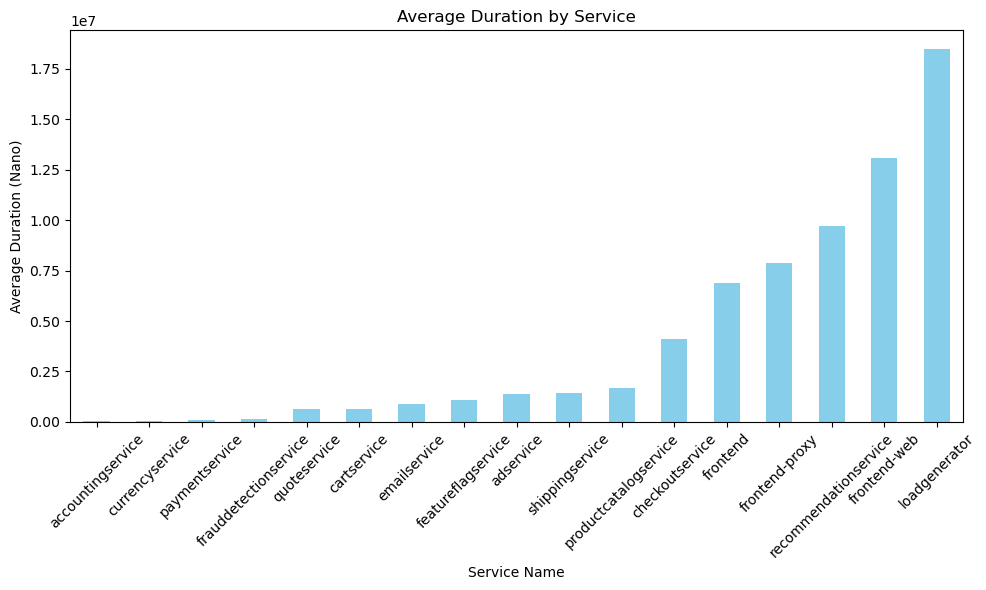

In [73]:
avg_duration_by_service = df.groupby('serviceName')['durationNano'].mean().sort_values()

# Plot bar graph for average duration by service
plt.figure(figsize=(10, 6))
avg_duration_by_service.plot(kind='bar', color='skyblue')
plt.xlabel('Service Name')
plt.ylabel('Average Duration (Nano)')
plt.title('Average Duration by Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Through this bar graph we can analyze which services has the maximum average span duration.

### Number of Service Requests In Every 10 Minutes

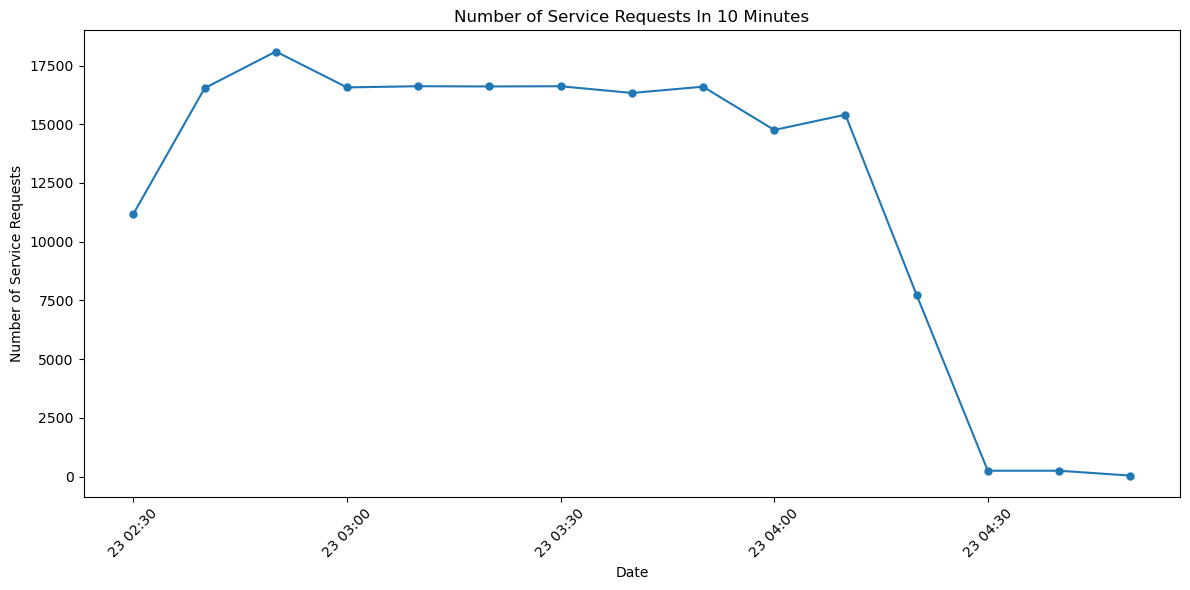

In [69]:
request_count_daily = df.resample('10T').size()

# Plot line graph for number of service requests over time
plt.figure(figsize=(12, 6))
plt.plot(request_count_daily.index, request_count_daily.values, marker='o', markersize=5)
plt.xlabel('Date')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests In Every 10 Minutes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Span Duration Of Each Services Over Time

Through this Scatter Plot we can analazye whether there is any unsual hike in the duration from its normal pattern

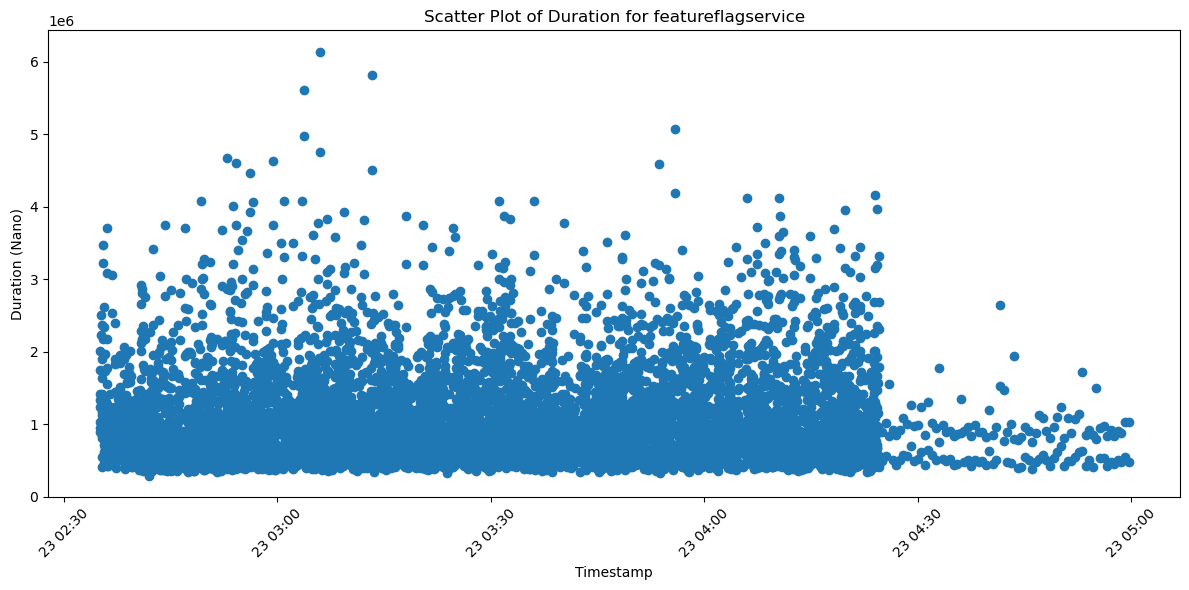

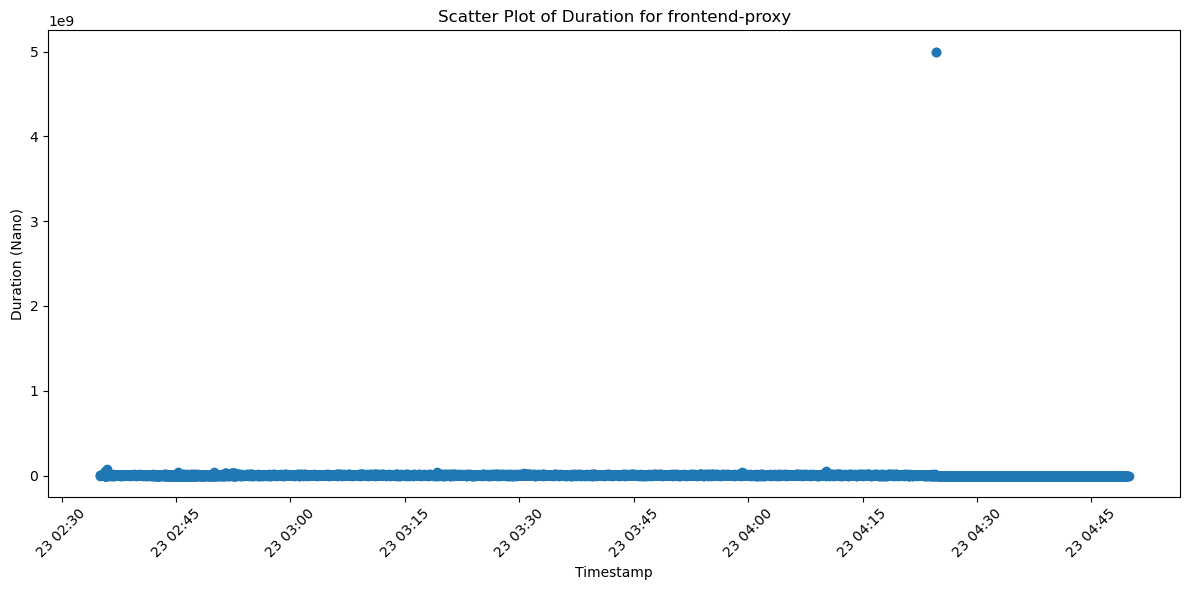

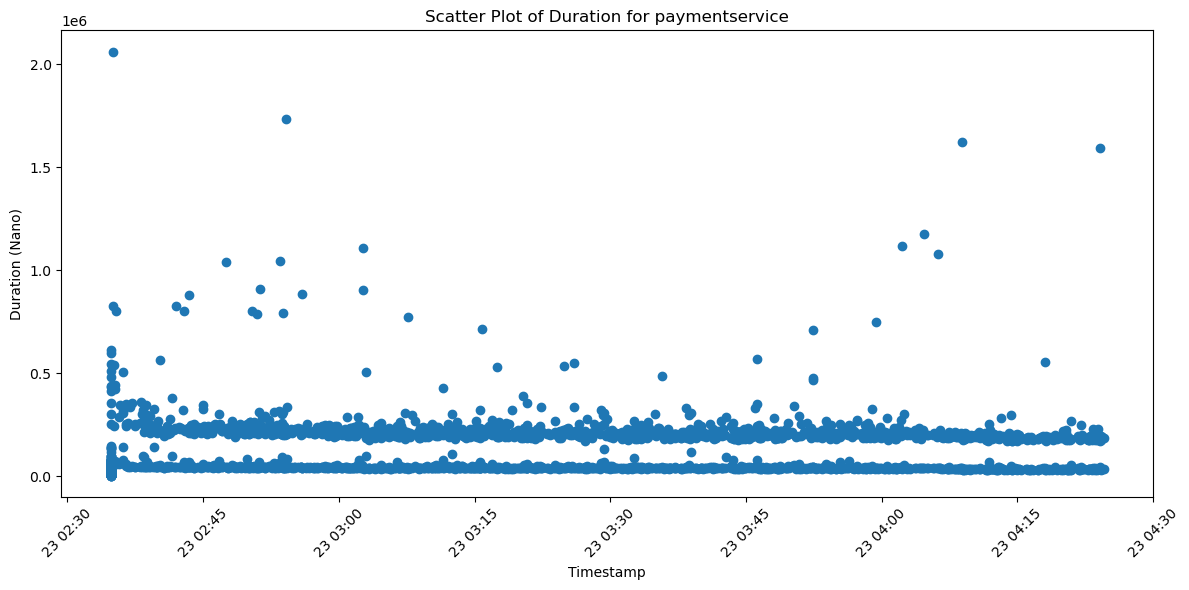

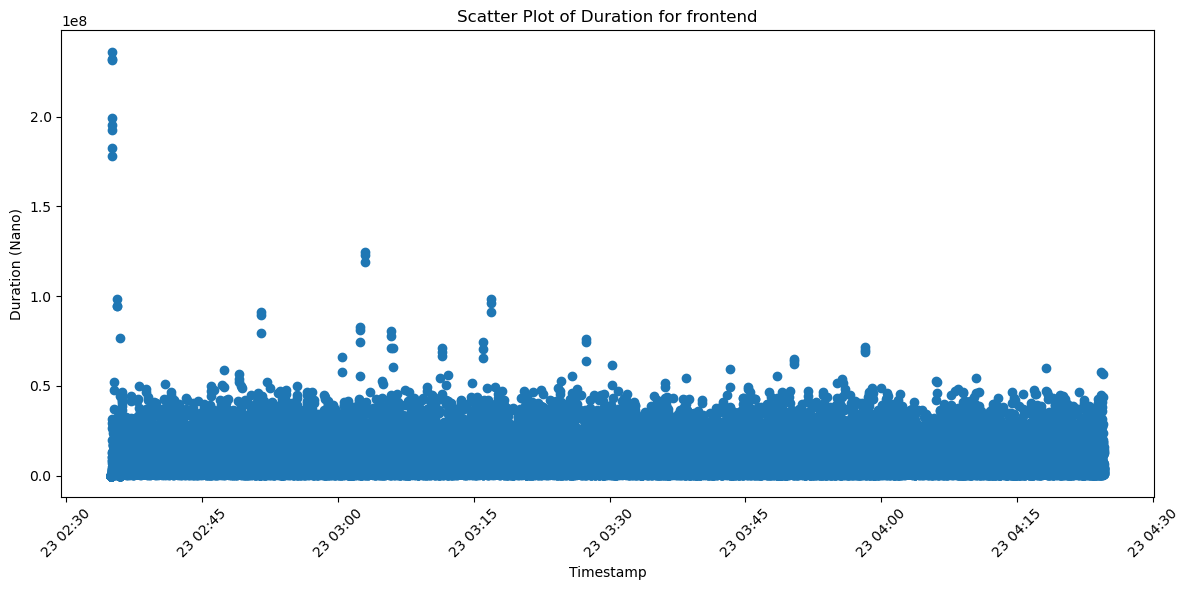

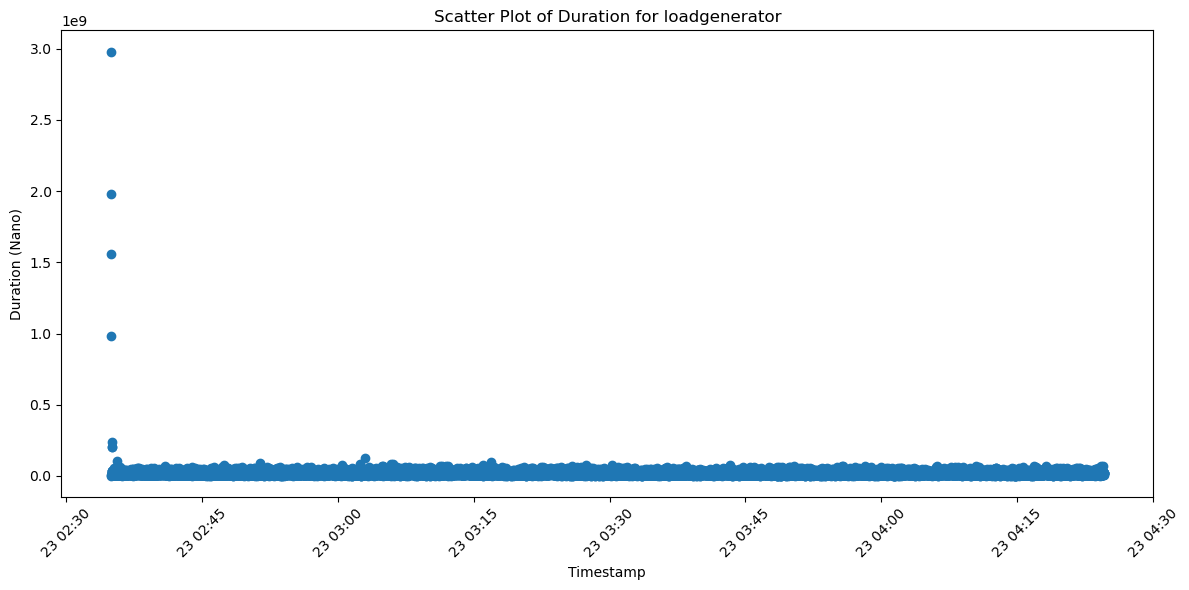

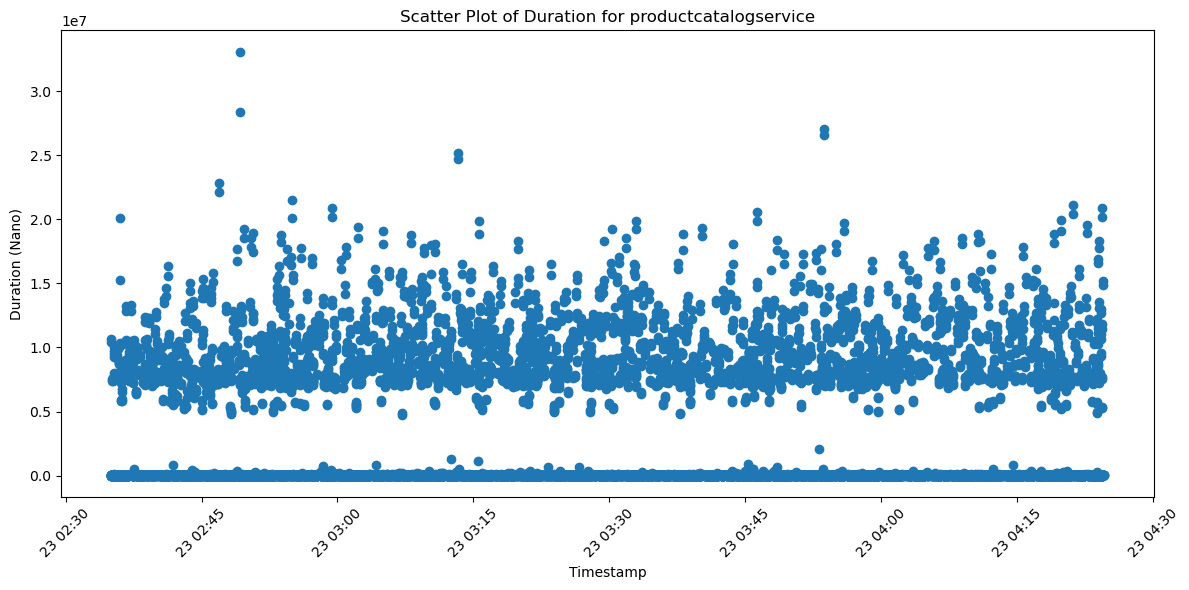

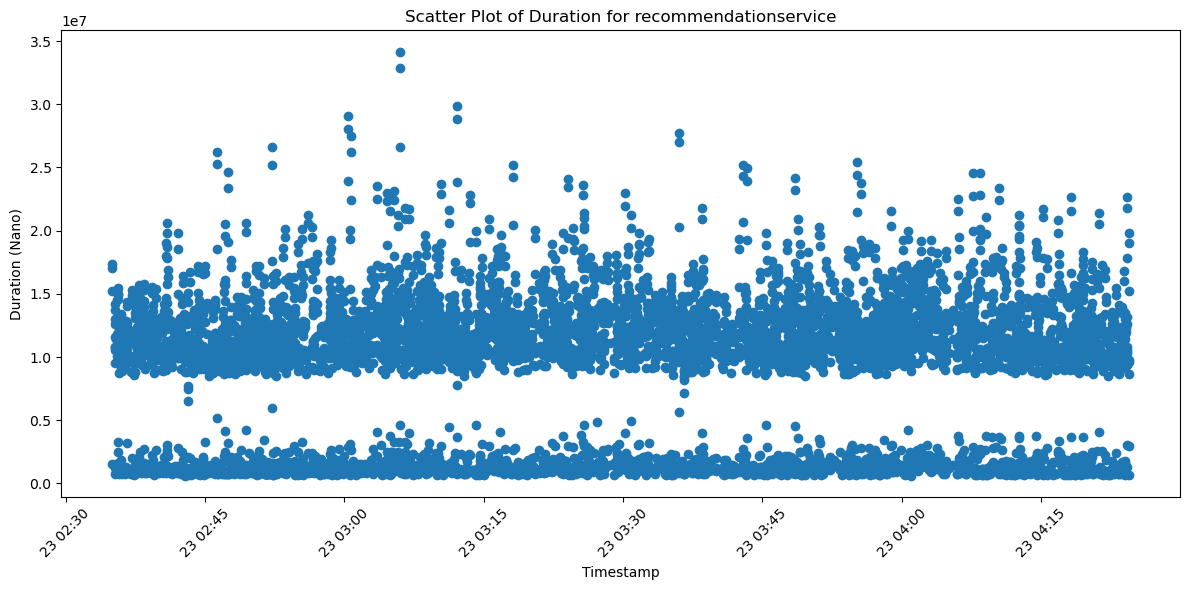

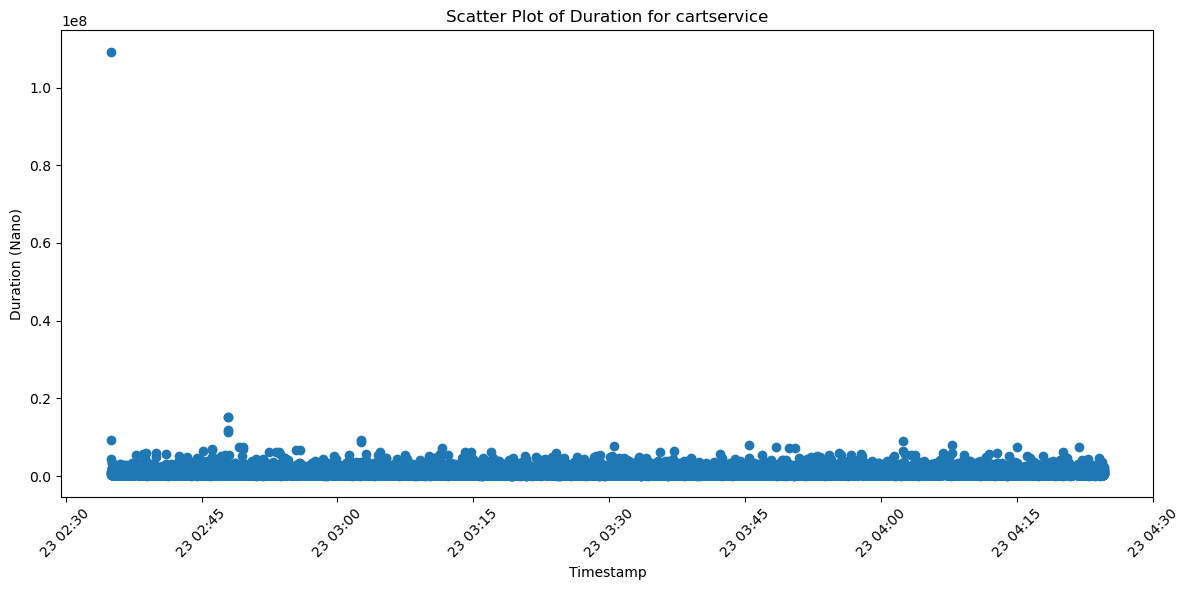

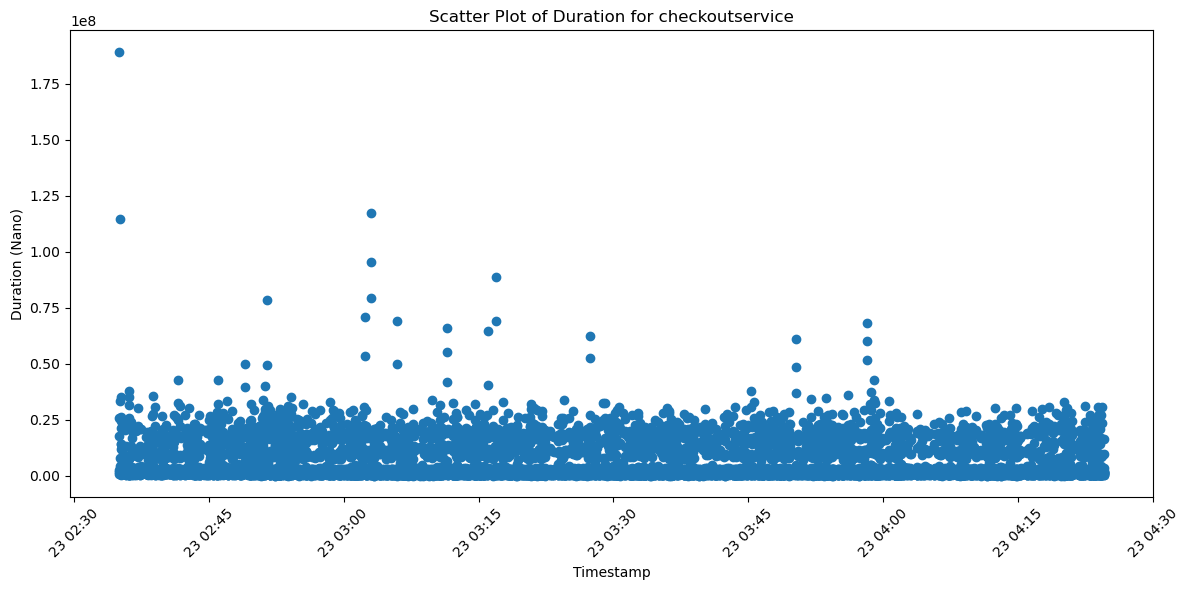

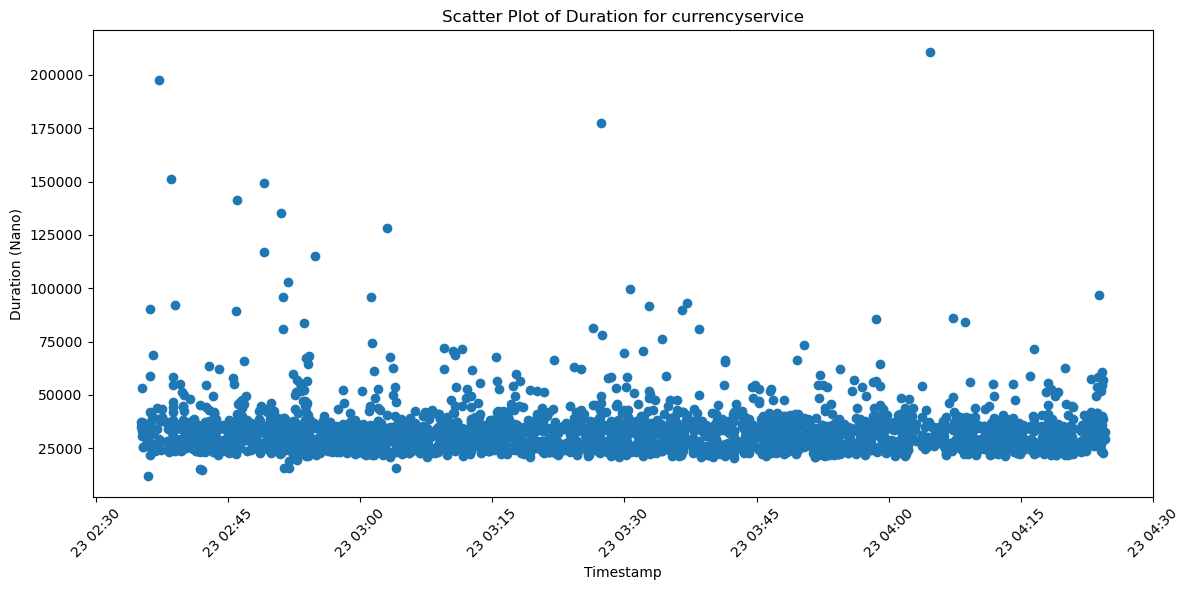

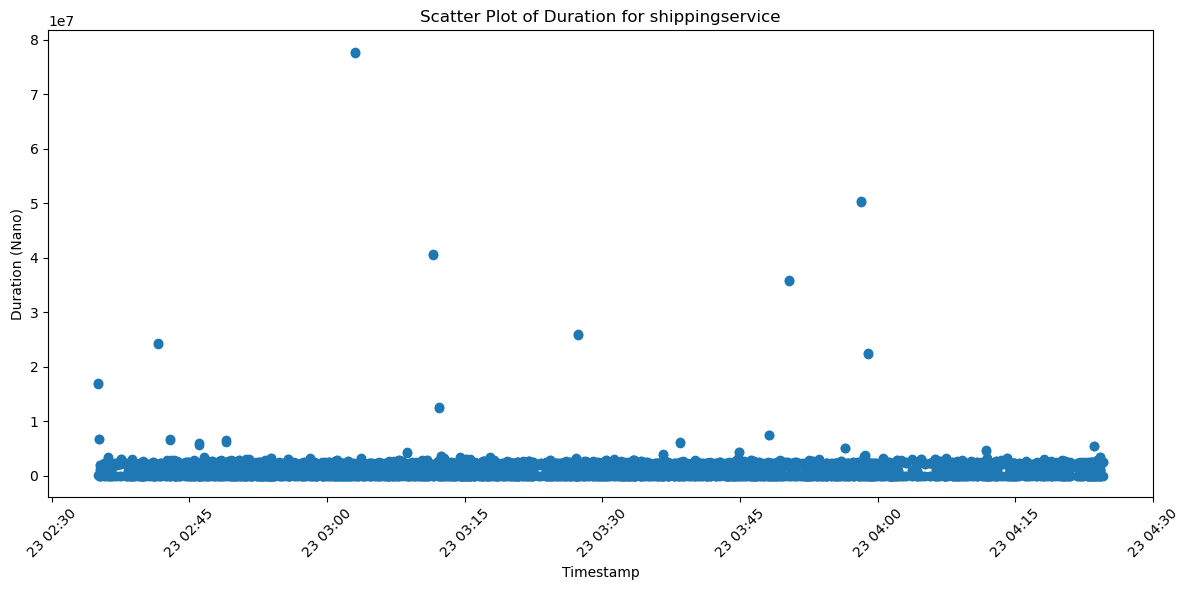

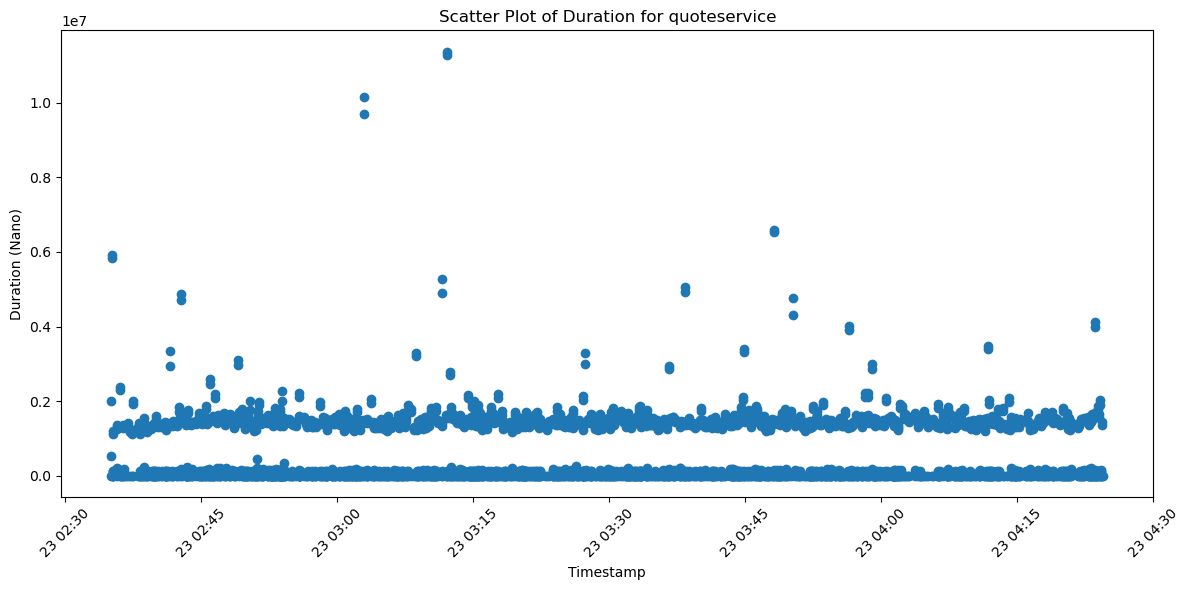

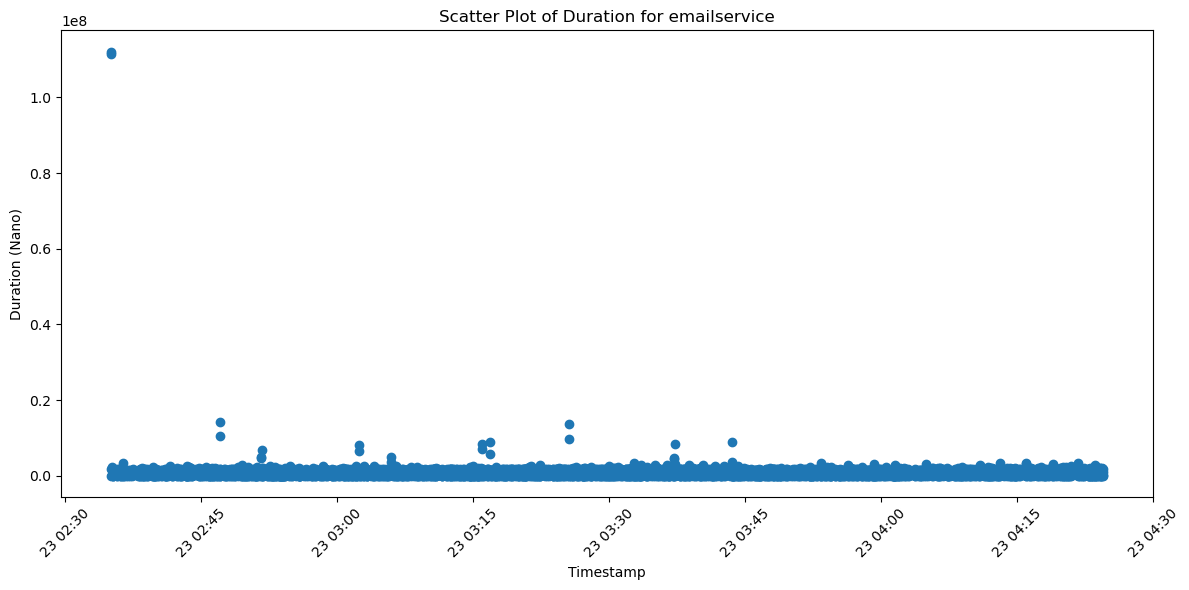

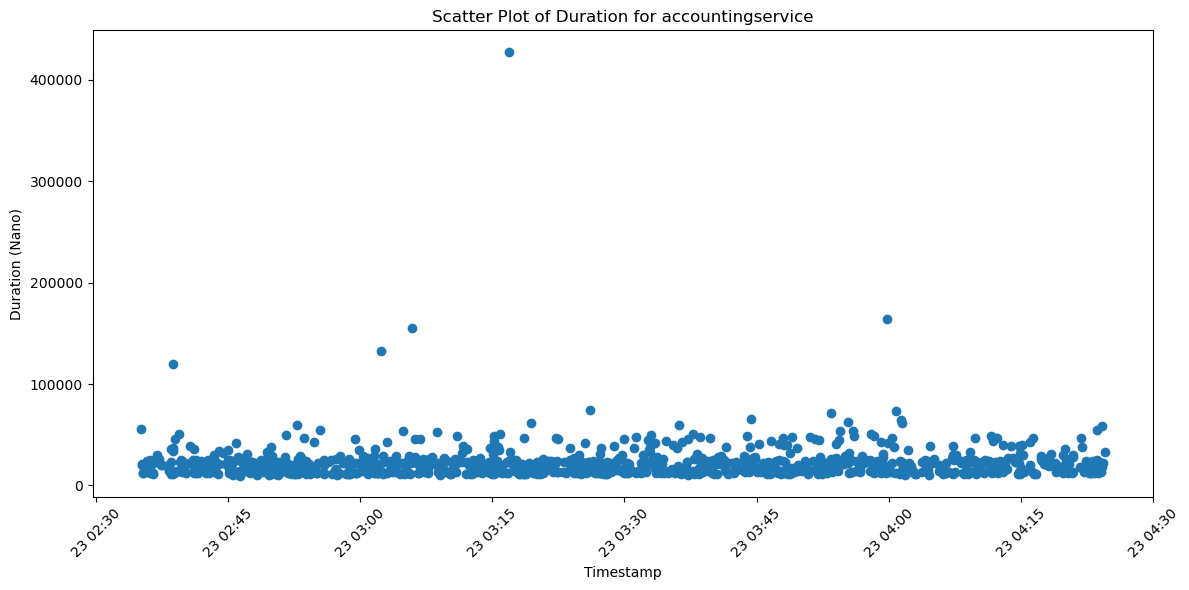

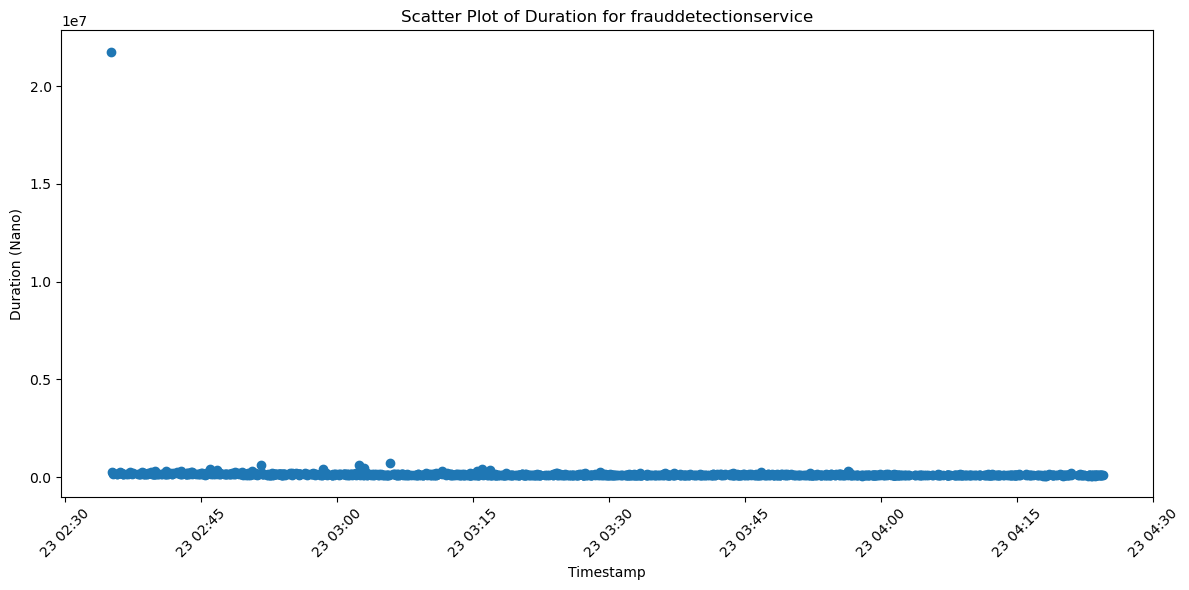

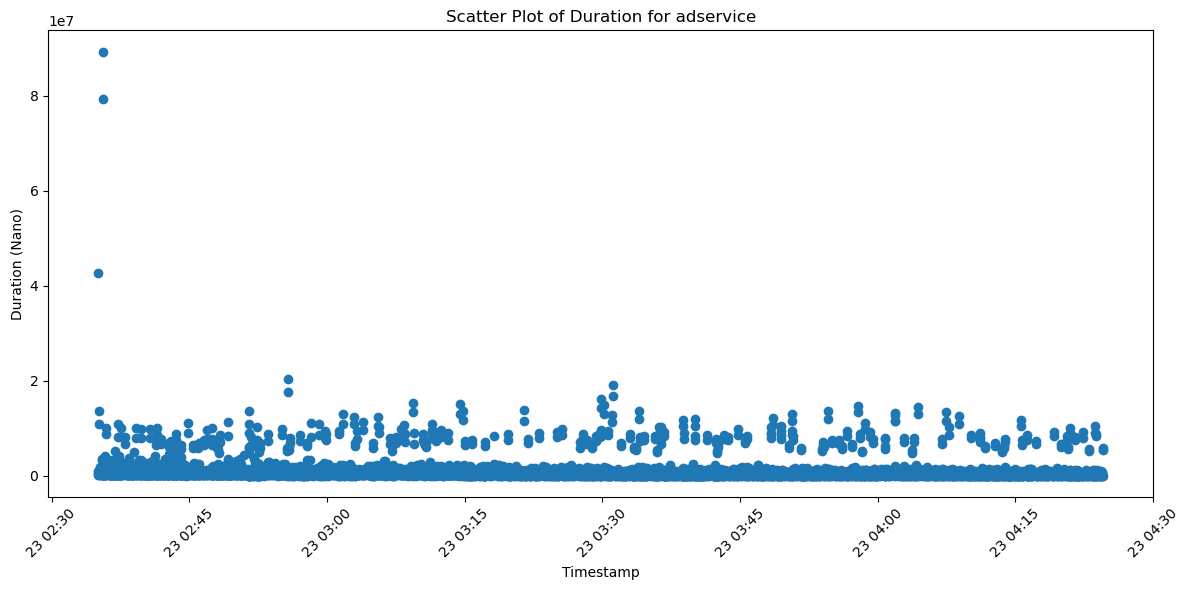

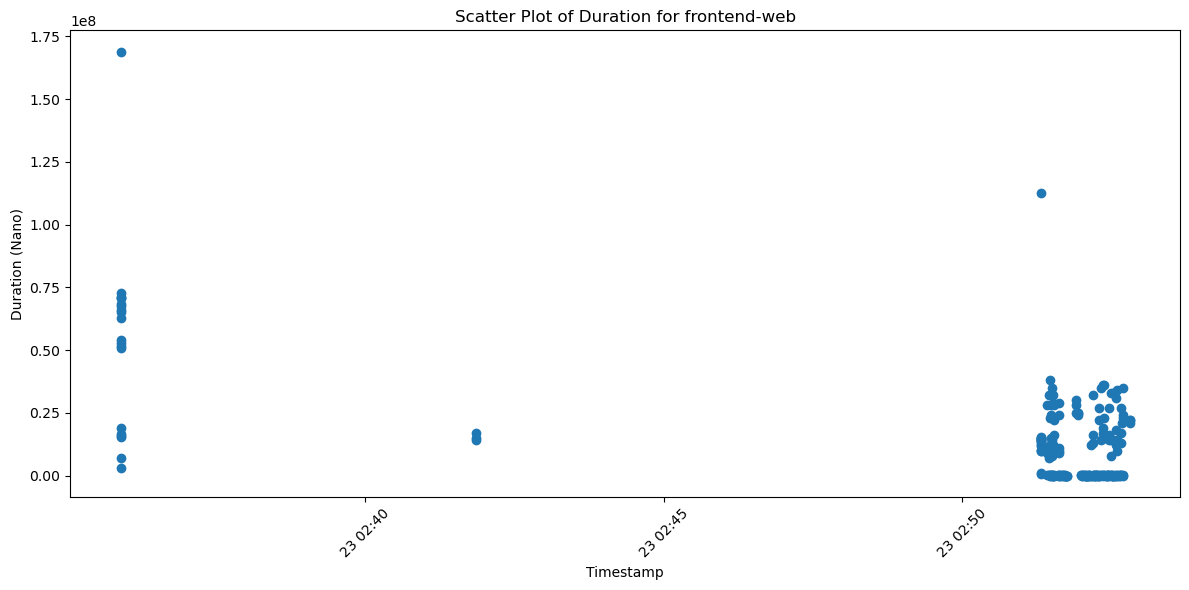

In [81]:
services = df['serviceName'].unique()

# Plot scatter plot for each service separately
for service in services:
    service_data = df[df['serviceName'] == service]
    plt.figure(figsize=(12, 6))
    plt.scatter(service_data['Timestamp'], service_data['durationNano'])
    plt.xlabel('Timestamp')
    plt.ylabel('Duration (Nano)')
    plt.title('Scatter Plot of Duration for ' + service)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 

<p style="font-size:130%;">For frontend-proxy, cart, shipping, email, accounting, and frauddetection service we can see a sudden hike in span duration without any progession or support<p>

<p style="font-size:130%;"> So by checking the log of these service during that timestamp, we can find the reason for the anomaly and validate the problem<p>

## Here we have taken the same scatter plot but classifed each points based on the method name, so we could get a more clear idea of which method caused the anomaly or hike in the span duration

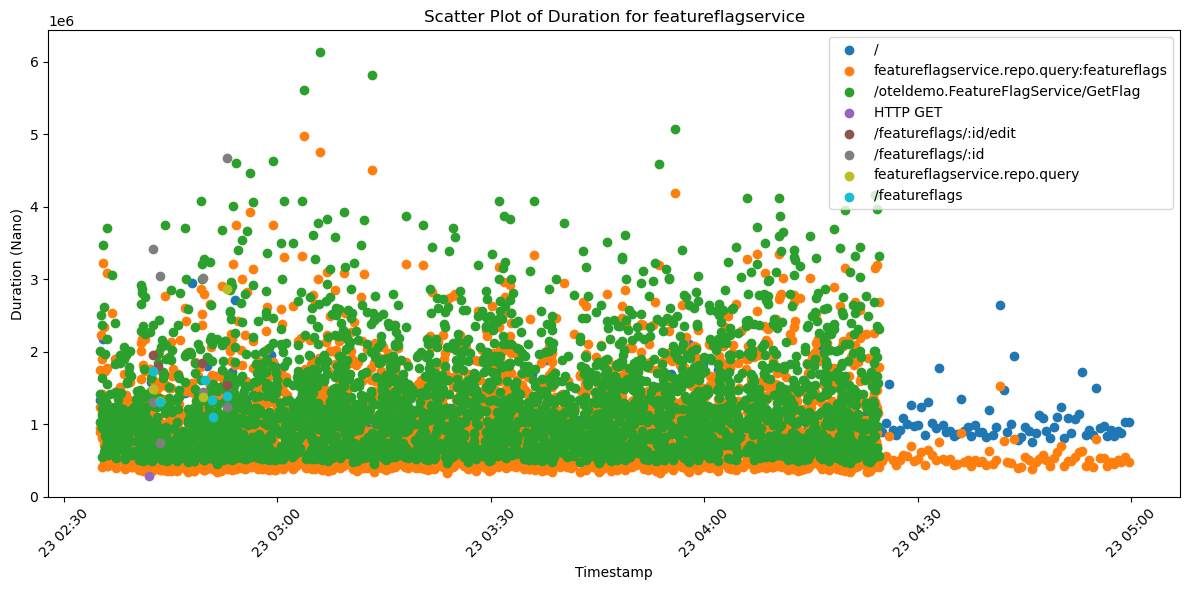

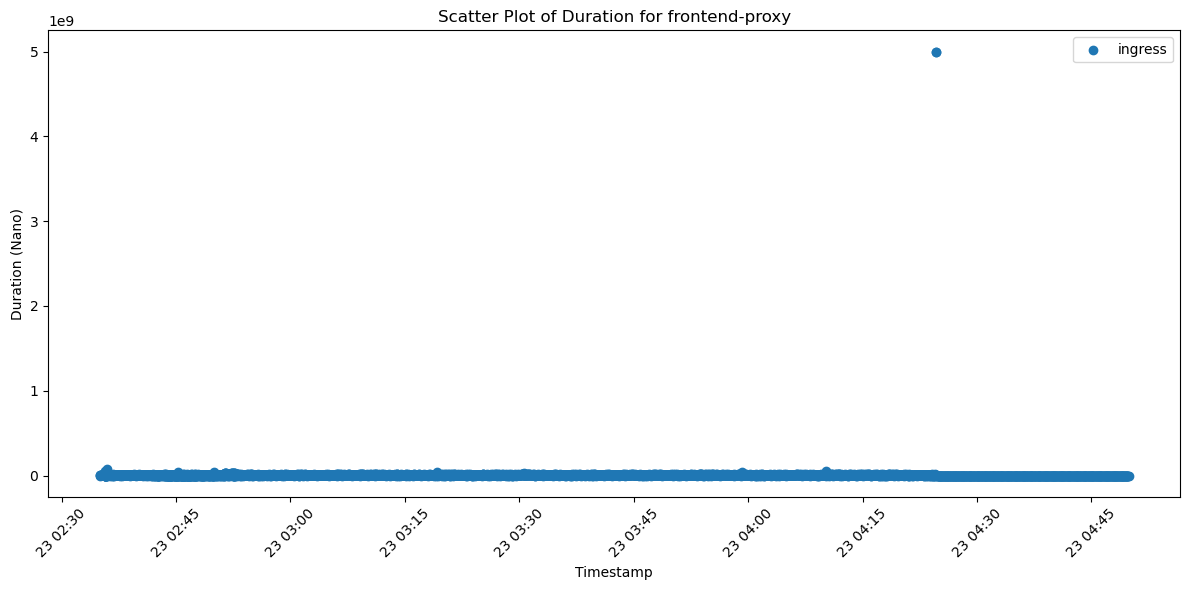

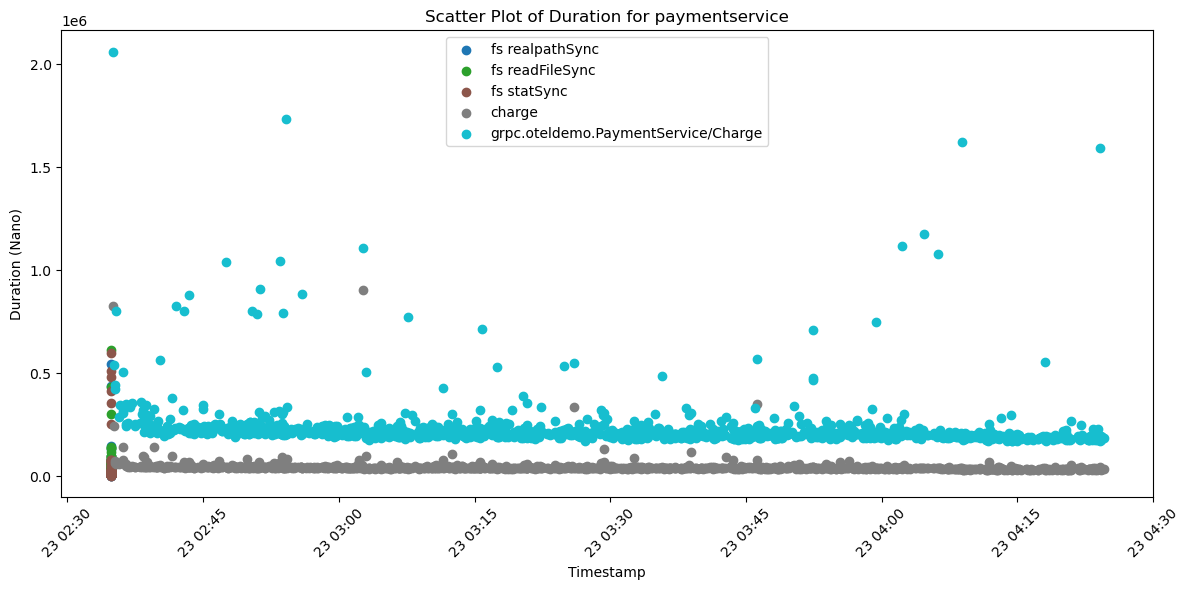

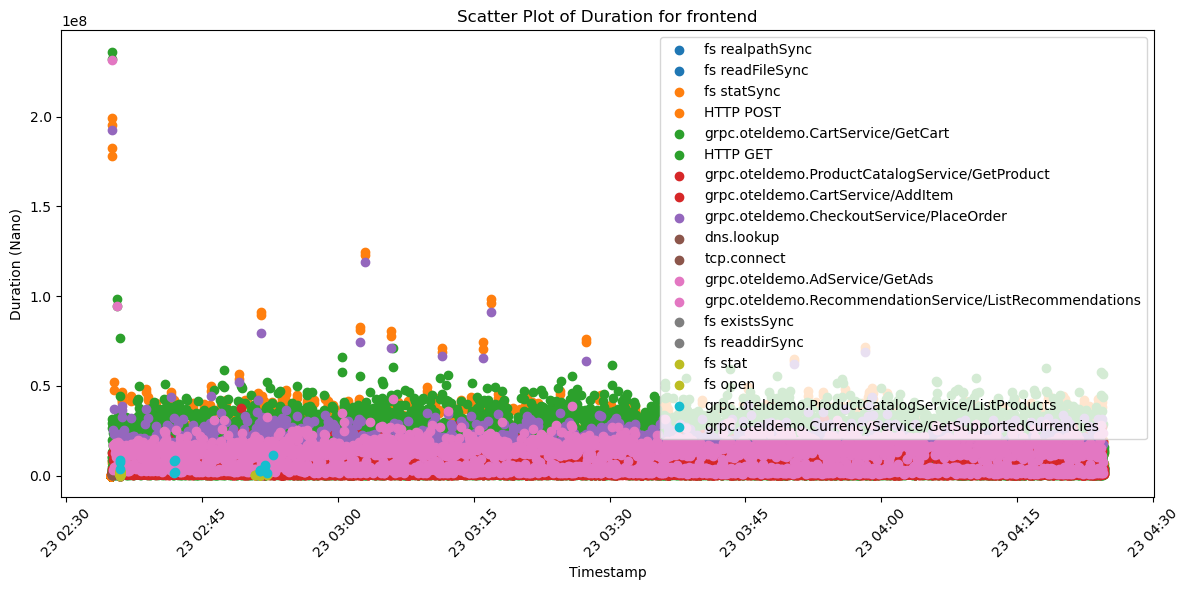

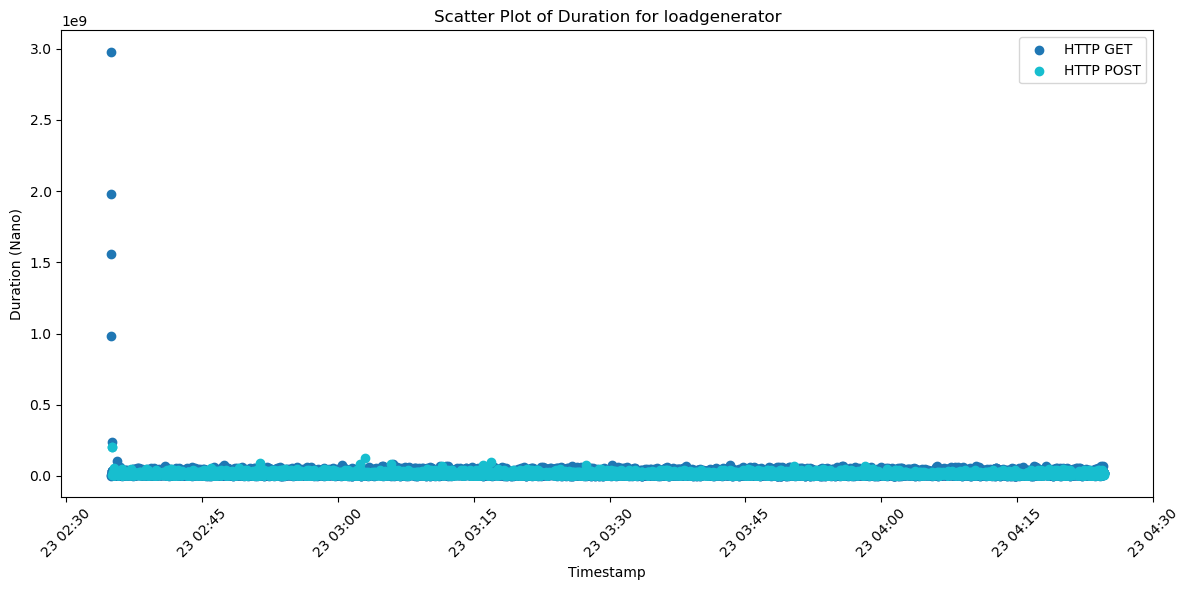

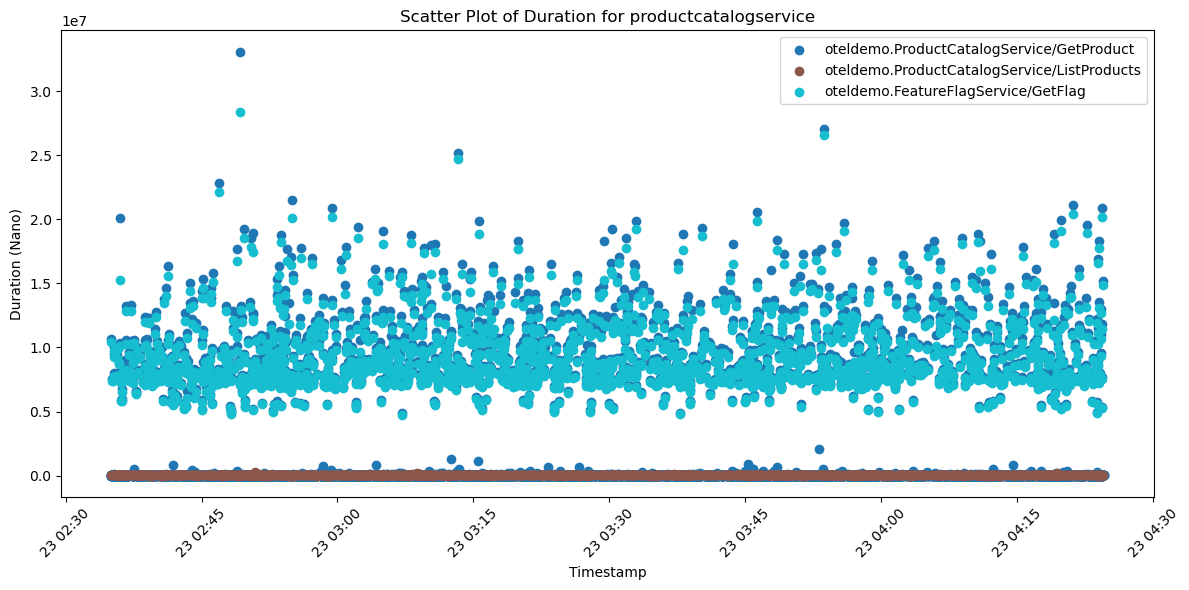

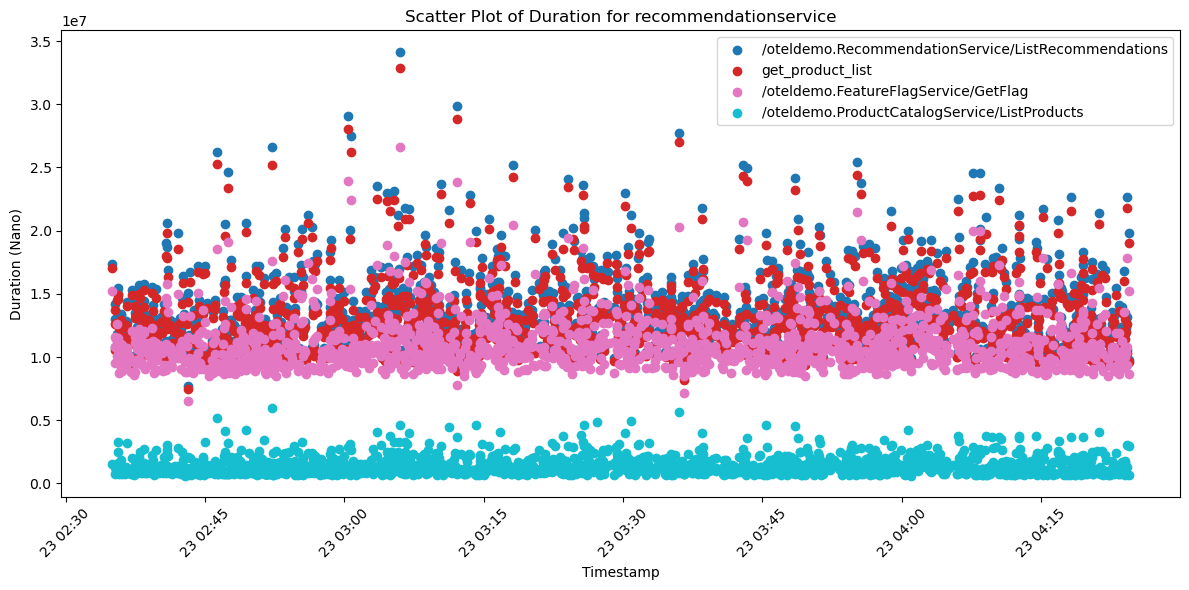

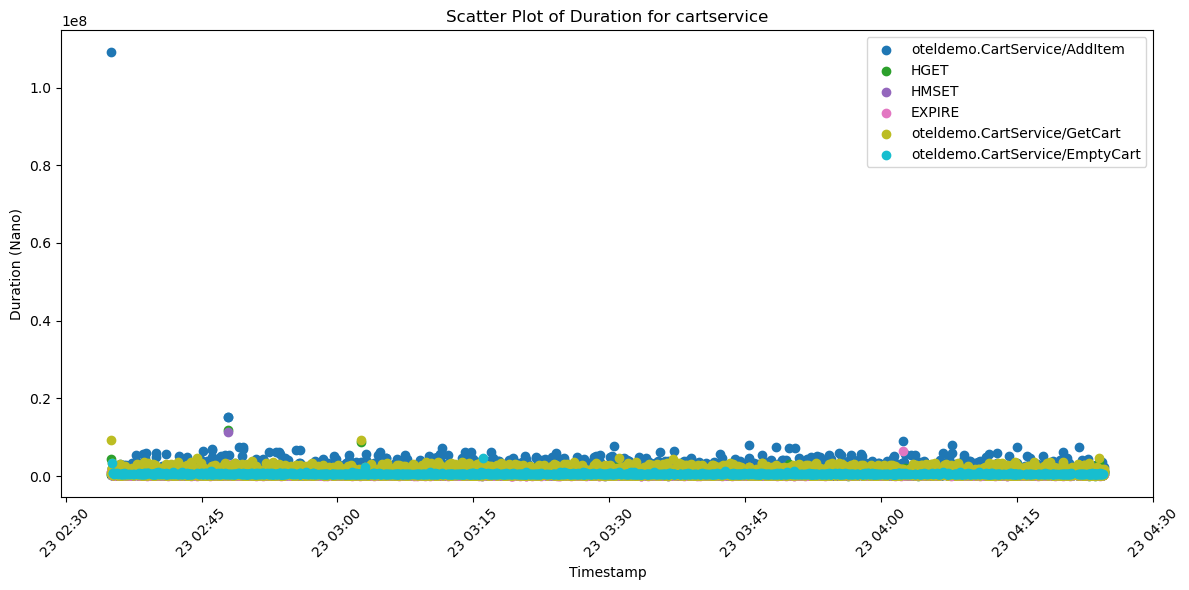

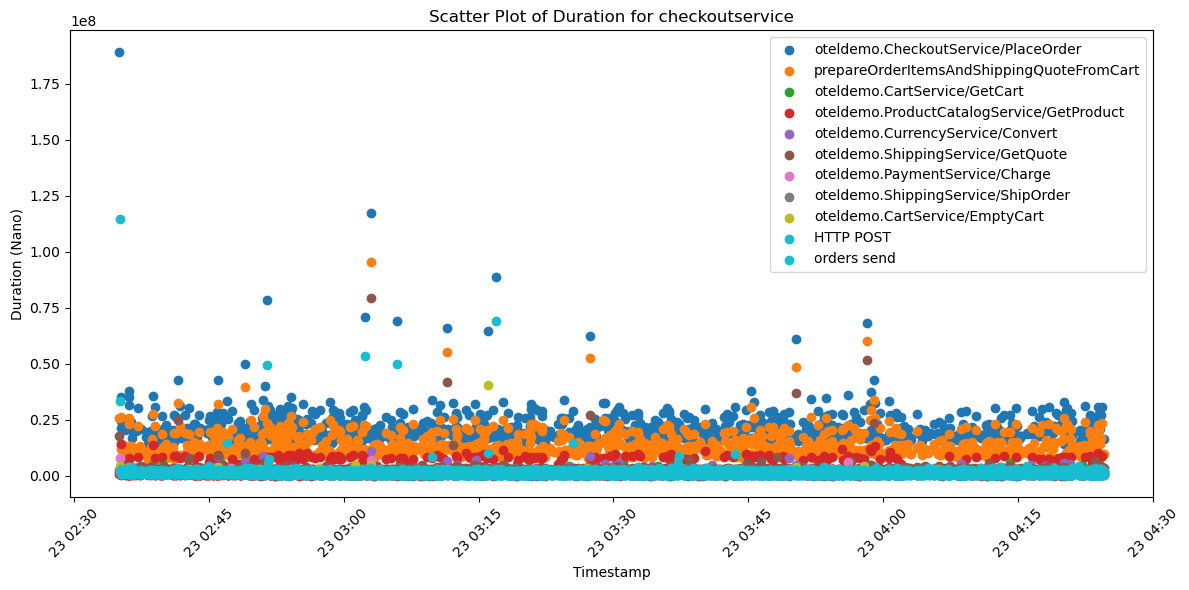

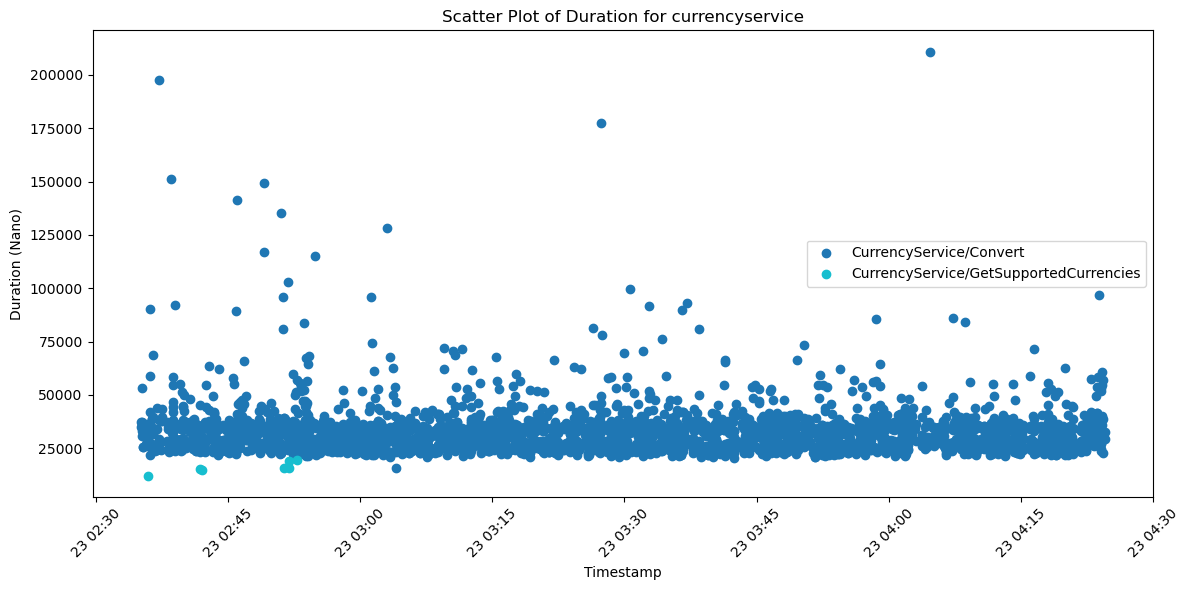

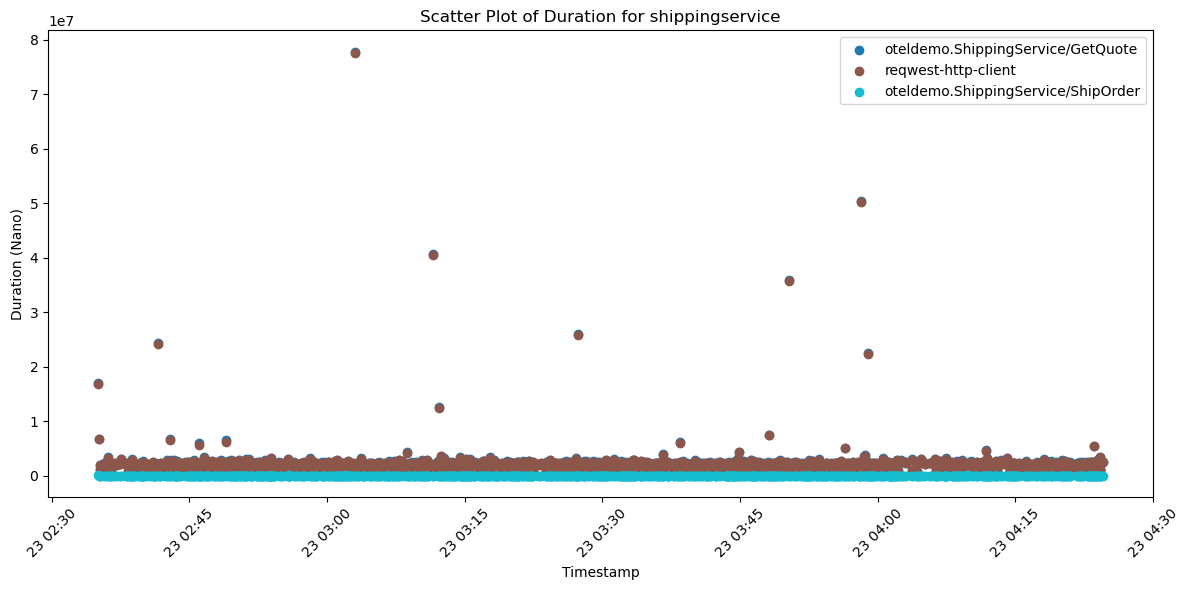

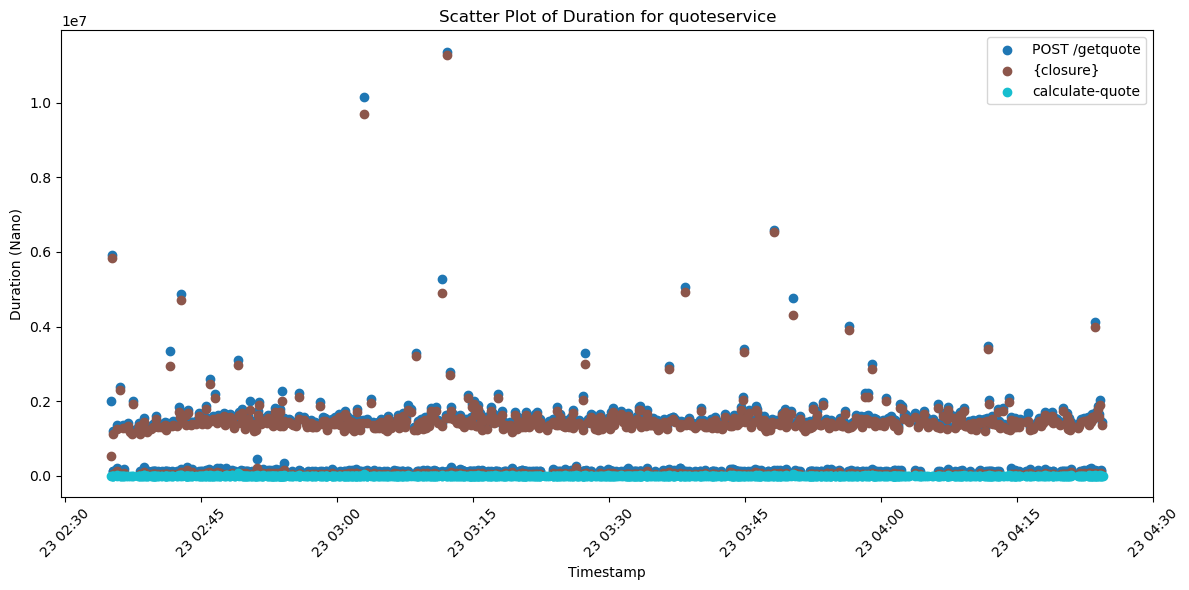

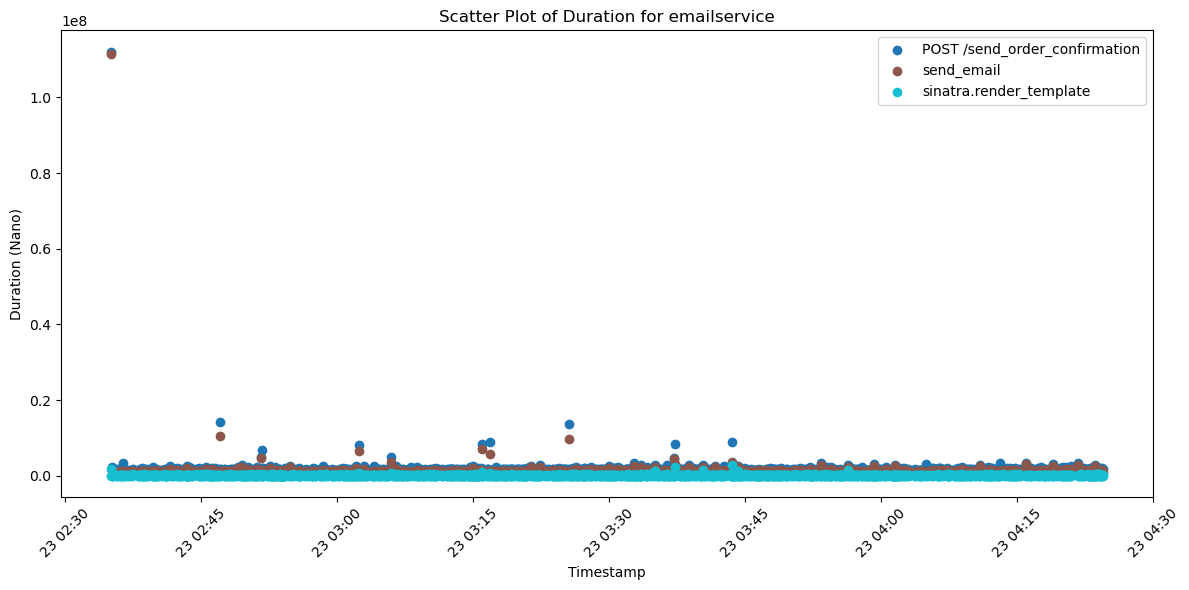

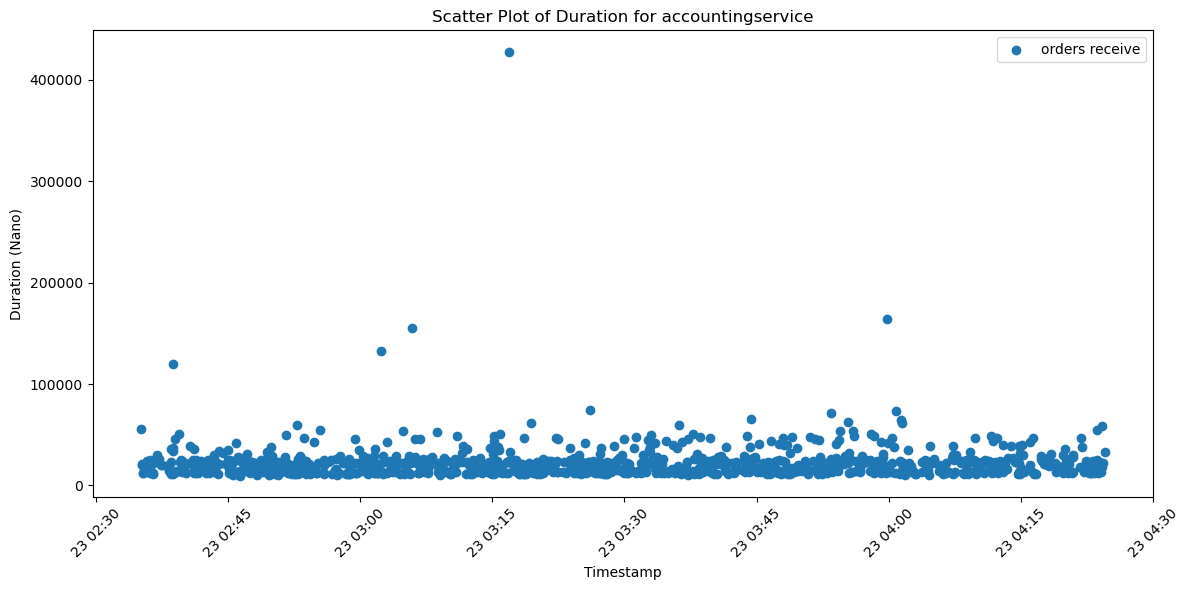

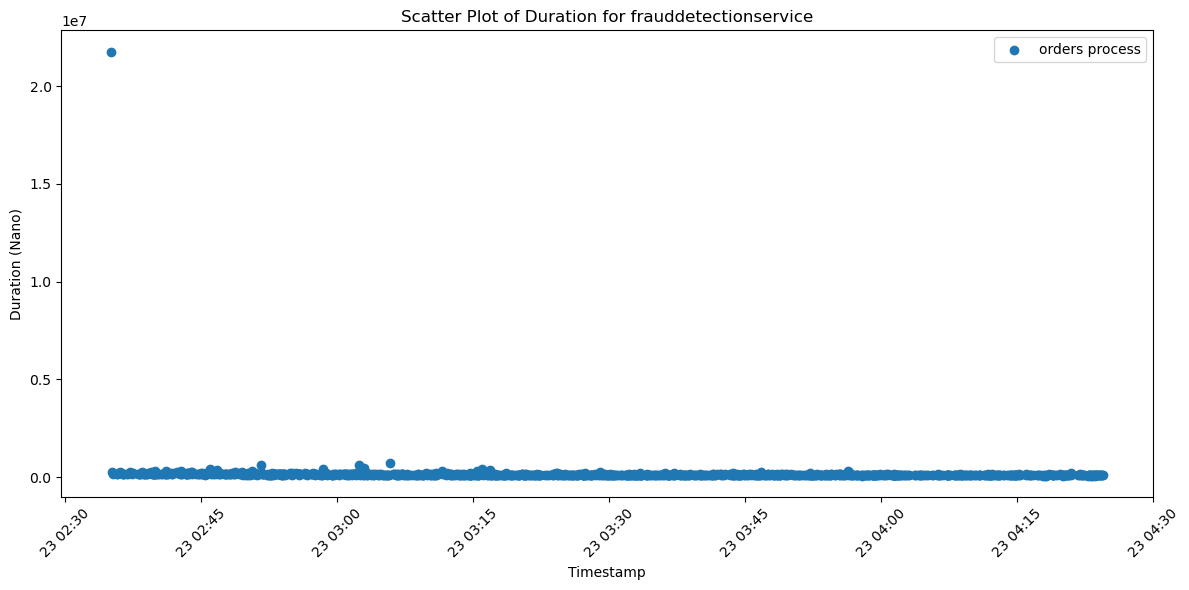

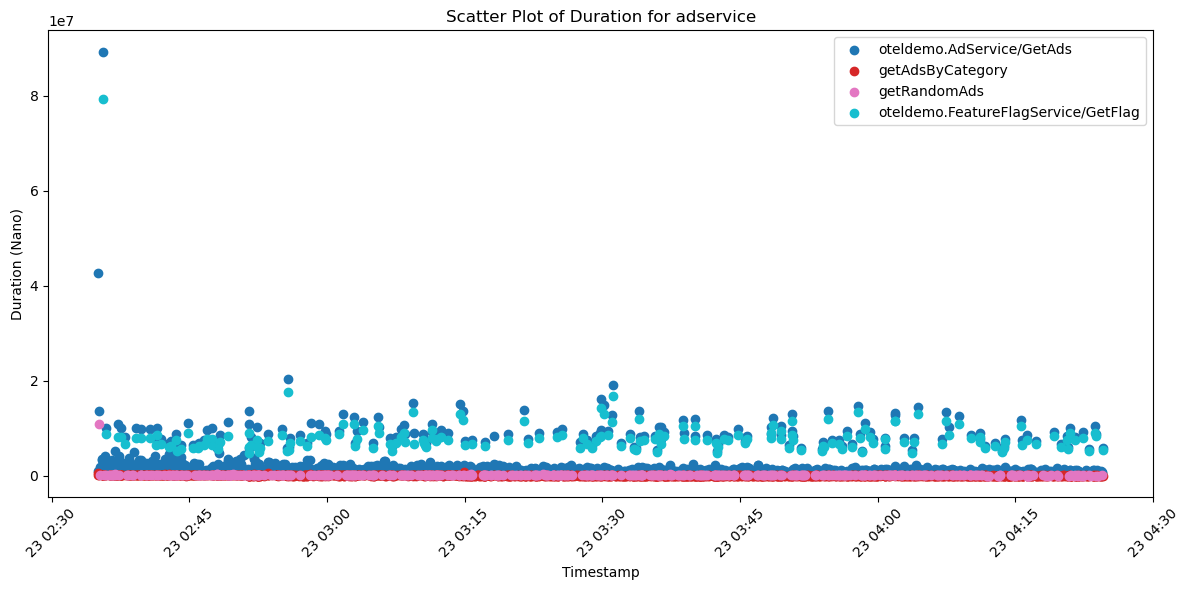

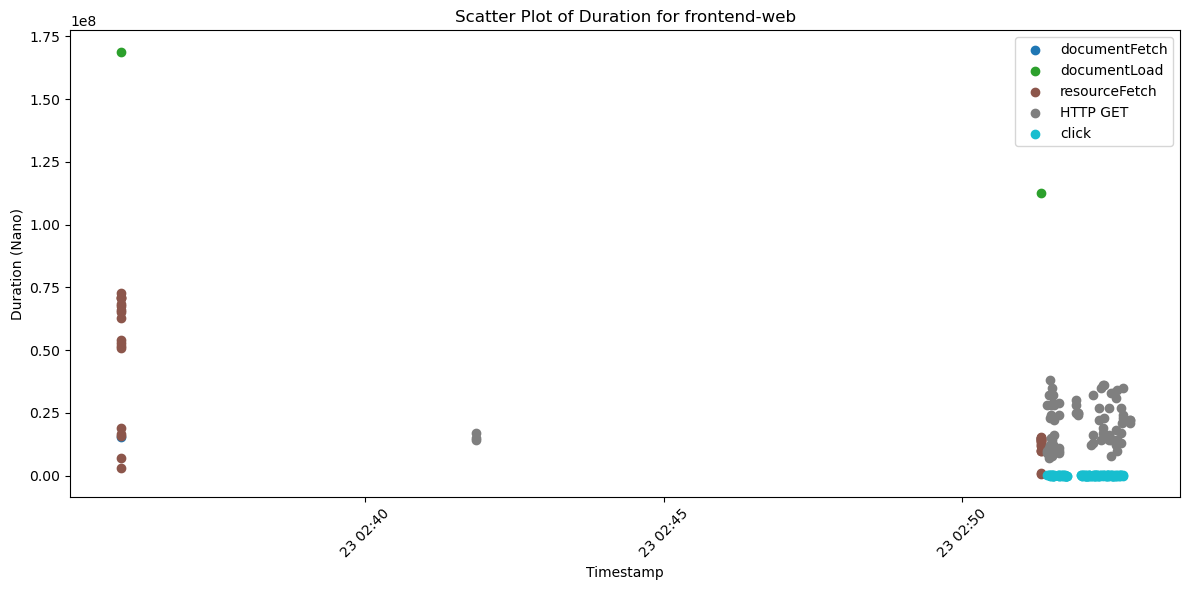

In [84]:
import numpy as np

# Assuming 'df' is your DataFrame containing the microservices trace data

# Get unique service names
services = df['serviceName'].unique()

# Plot scatter plot for each service separately
for service in services:
    service_data = df[df['serviceName'] == service]
    unique_names = service_data['Name'].unique()
    
    # Define a color palette with enough colors for all unique names
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_names)))
    
    # Plot scatter plot for each unique name
    plt.figure(figsize=(12, 6))
    for name, color in zip(unique_names, colors):
        name_data = service_data[service_data['Name'] == name]
        plt.scatter(name_data['Timestamp'], name_data['durationNano'], color=color, label=name)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Duration (Nano)')
    plt.title('Scatter Plot of Duration for ' + service)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()